In [1]:
!wget $(yadisk-direct https://disk.yandex.ru/d/2LaYWIY5jb_Mcw) -O ./csv/L5.zip && cd ./csv/; unzip -j L5.zip 

--2021-10-17 15:42:40--  https://downloader.disk.yandex.ru/zip/7dcf6de57648f7d589bfeb8c7ff25046cd2967d43994bce24f31a8e44575fab8/616c44e8/WUZOandzb1QrMnYrTVROTW5IakZxaU01N3R4T2QyU0xkbWhrVDV3NVlQOTBwS29ZeG9mczJaSlVhdXJrNERHZXEvSjZicG1SeU9Kb25UM1ZvWG5EYWc9PTo=?uid=0&filename=%D0%A4%D0%B8%D0%BD%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9%20%D0%BF%D1%80%D0%BE%D0%B5%D0%BA%D1%82.zip&disposition=attachment&hash=YFNjwsoT%2B2v%2BMTNMnHjFqiM57txOd2SLdmhkT5w5YP90pKoYxofs2ZJUaurk4DGeq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&owner_uid=125175473&tknv=v2
Resolving downloader.disk.yandex.ru (downloader.disk.yandex.ru)... 77.88.21.127, 2a02:6b8::2:127
Connecting to downloader.disk.yandex.ru (downloader.disk.yandex.ru)|77.88.21.127|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://downloader-default23e.disk.yandex.net/rzip/7dcf6de57648f7d589bfeb8c7ff25046cd2967d43994bce24f31a8e44575fab8/616c44e8/WUZOandzb1QrMnYrTVROTW5IakZxaU01N3R4T2QyU0xkbWhrVDV3NVlQOTBwS29ZeG9mczJ

In [27]:
import os
import sys
sys.path.append('./uplift-campaign/')

import pandas as pd
import numpy as np
import sidetable
import dask.dataframe as dd
import pickle
import json
import sklearn.base as skbase
import sklearn.pipeline as skpipe
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style(style='white') 
%matplotlib inline

In [2]:
import upcampaign.datalib as datalib
import upcampaign.datalib.connection as connection
import upcampaign.datalib.features.compute as fcompute
# import upcampaign.model_utils as mu

In [3]:
import lightgbm as lgb
import causalml.metrics as cmetrics
import causalml.inference.meta.rlearner as rlearner

from sklearn.model_selection import train_test_split

## Load'n'cook

### engine

In [4]:
data_root_path = './csv/'

receipts = dd.read_parquet(os.path.join(data_root_path, 'receipts.parquet'))
campaigns = dd.read_csv(os.path.join(data_root_path, 'campaigns.csv'))
client_profile = dd.read_csv(os.path.join(data_root_path, 'customers.csv'))

In [5]:
engine = connection.Engine(tables={
    'receipts': receipts,
    'campaigns': campaigns,
    'client_profile': client_profile
})

## LOOKUP

In [27]:
client_profile.head()

,Unnamed: 0,customer_id,age,location
0,0,0,56,Oxenfurt
1,1,1,53,Hindarsfjall
2,2,2,41,Hindarsfjall
3,3,3,60,Kaer_Trolde
4,4,4,22,Spikeroog


In [666]:
client_profile.describe().compute()

,Unnamed: 0,customer_id,age
count,2.000000e+06,2.000000e+06,2.000000e+06
mean,9.999995e+05,9.999995e+05,4.450815e+01
std,5.773504e+05,5.773504e+05,1.443533e+01
min,0.000000e+00,0.000000e+00,2.000000e+01
25%,4.999998e+05,4.999998e+05,3.200000e+01
50%,9.999995e+05,9.999995e+05,4.500000e+01
75%,1.499999e+06,1.499999e+06,5.700000e+01
max,1.999999e+06,1.999999e+06,6.900000e+01


In [350]:
client_profile.location.value_counts().compute()

Novigrad        300918
Beauclair       300689
Oxenfurt        299988
Spikeroog       299775
Hindarsfjall    299456
Kaer_Trolde     299075
Crows_perch     200099
Name: location, dtype: int64

In [6]:
age_min = client_profile.age.min().compute()
age_max = client_profile.age.max().compute()
unique_age = len(client_profile.age.unique().compute())

In [7]:
receipts.head()

,customer_id,date,purchase_amt,discount,purchase_sum
26,26,0,12.125273,0,970.021866
53,53,0,34.357035,0,2748.562788
56,56,0,8.695825,0,695.666022
58,58,0,28.299046,0,2263.923641
64,64,0,32.547511,0,2603.800857


In [12]:
receipts.date.describe().compute()

count    3.174177e+07
mean     1.244958e+02
std      7.213806e+01
min      0.000000e+00
25%      6.200000e+01
50%      1.240000e+02
75%      1.870000e+02
max      2.490000e+02
Name: date, dtype: float64

In [23]:
receipts.query("discount > 0").count().compute()

customer_id     226525
date            226525
purchase_amt    226525
discount        226525
purchase_sum    226525
dtype: int64

In [240]:
ref_cust = receipts.query("(customer_id == 4) & ((date >= 30) & (date <= 131))")[['purchase_sum', 'purchase_amt']].compute()

In [241]:
ref_cust.purchase_sum.sum()

4326.177339487327

In [22]:
receipts.query("customer_id == 1999883").compute()

,customer_id,date,purchase_amt,discount,purchase_sum
1999883,1999883,31,42.583485,0,3406.678836
1999883,1999883,158,35.229005,0,2818.320362
1999883,1999883,231,35.997293,0,2879.783445


In [19]:
receipts[receipts.date < 132].describe(include='all').compute()

,customer_id,date,purchase_amt,discount,purchase_sum
count,1.676856e+07,1.676856e+07,1.676856e+07,1.676856e+07,1.676856e+07
mean,9.991867e+05,6.556267e+01,1.646025e+01,5.403566e-01,1.316820e+03
std,5.777243e+05,3.810540e+01,9.321455e+00,4.617606e+00,7.457164e+02
min,0.000000e+00,0.000000e+00,1.026834e+00,0.000000e+00,8.214675e+01
25%,4.979280e+05,3.300000e+01,9.502695e+00,0.000000e+00,7.602156e+02
50%,9.985160e+05,6.600000e+01,1.478685e+01,0.000000e+00,1.182948e+03
75%,1.499683e+06,9.900000e+01,2.197073e+01,0.000000e+00,1.757658e+03
max,1.999999e+06,1.310000e+02,7.512826e+01,4.000000e+01,6.010261e+03


In [9]:
campaigns.head()

,Unnamed: 0,customer_id,n_offer_days,date,target_group_flag
0,0,0,7,102,1
1,1,1,7,102,1
2,2,2,7,102,1
3,3,3,7,102,1
4,4,4,7,102,1


In [26]:
campaigns.customer_id.unique().count().compute()

500000

In [21]:
campaigns.query("customer_id  == 108").compute()

,Unnamed: 0,customer_id,n_offer_days,date,target_group_flag
108,108,108,7,102,1


## ETL

In [30]:
BINS = 10
PRICE = 80.
MARKUP = 52.
MARKRATIO = 0.35
DISCOUNT = 40.
COMMUNICATION_COST = 1.

age_min = client_profile.age.min().compute()
age_max = client_profile.age.max().compute()
unique_age = len(client_profile.age.unique().compute())

In [32]:
data_config = {
    'extract': [        
        {
            'name': 'receipts_basic',
            'args': {'delta': 70, 'date_to': 102}
        },         
        {
            'name': 'receipts_basic',
            'args': {'delta': 65, 'date_to': 102}
        },        
        {
            'name': 'receipts_basic',
            'args': {'delta': 60, 'date_to': 102}
        },
        {
            'name': 'receipts_basic',
            'args': {'delta': 55, 'date_to': 102}
        },        
        {
            'name': 'receipts_basic',
            'args': {'delta': 50, 'date_to': 102}
        },
        {
            'name': 'receipts_basic',
            'args': {'delta': 45, 'date_to': 102}
        },        
        {
            'name': 'receipts_basic',
            'args': {'delta': 40, 'date_to': 102}
        },
        {
            'name': 'receipts_basic',
            'args': {'delta': 35, 'date_to': 102}
        },  
        {
            'name': 'receipts_basic',
            'args': {'delta': 31, 'date_to': 102}
        },        
        {
            'name': 'receipts_basic',
            'args': {'delta': 25, 'date_to': 102}
        },        
        {
            'name': 'receipts_basic',
            'args': {'delta': 20, 'date_to': 102}
        },
        {
            'name': 'receipts_basic',
            'args': {'delta': 15, 'date_to': 102}
        },
        {
            'name': 'receipts_basic',
            'args': {'delta': 10, 'date_to': 102}
        },        
        {
            'name': 'receipts_basic',
            'args': {'delta': 7, 'date_to': 102}
        },
        {
            'name': 'receipts_basic',
            'args': {'delta': 5, 'date_to': 102}
        },          
        {
            'name': 'receipts_basic',
            'args': {'delta': 2, 'date_to': 102}
        },        
        {
            'name': 'receipts_basic',
            'args': {'delta': 30, 'date_to': 132}
        },        
        {
            'name': 'age_gender',
            'args': {}
        },
        {
            'name': 'target_from_campaigns',
            'args': {'date_to': 102}
        }
    ],
    'transform': [
        {
            'name': 'expression',
            'args': {
                'expression': f"{{d}}['purchase_sum_w_disc_sum__30d'].fillna(0) - {{d}}['purchase_amt_sum__30d'].fillna(0) * {MARKUP} - {{d}}['target_group_flag'].fillna(0) * {COMMUNICATION_COST}",
                'col_result': 'target_profit'
            }
        },
#         {
#             'name': 'expression',
#             'args': {
#                 'expression': f"{{d}}['purchase_sum_sum__102d'].fillna(0) * {MARKRATIO} - {{d}}['discount_flag_sum__102d'].fillna(0) * {DISCOUNT} - {{d}}['target_group_flag'].fillna(0) * {COMMUNICATION_COST}",
#                 'col_result': 'target_profit_2'
#             }
#         },        
#         {
#             'name': 'expression',
#             'args': {
#                 'expression': "{d}['purchase_sum_sum__50d'] / {d}['date_count__50d']",
#                 'col_result': 'purchase_sum_per_day__50d'
#             }
#         },
#         {
#             'name': 'expression',
#             'args': {
#                 'expression': "{d}['purchase_sum_sum__60d'] / {d}['date_count__60d']",
#                 'col_result': 'purchase_sum_per_day__60d'
#             }
#         }, 
        {
            'name': 'binning',
            'args': {
                'col_value': 'age',
                'col_result': 'age_bin',
                'bins': np.linspace(age_min, age_max, BINS).tolist(),
                'labels': range(0, min(unique_age, BINS)+1)
            }
        },        
        {
            'name': 'one_hot_encode',
            'args': {
                'cols': ['location']
            }
        }
    ]
}


## Extraction

In [33]:
raw_data = fcompute.extract_features(engine, config=data_config['extract'])

In [34]:
raw_data = raw_data.compute()

In [125]:
raw_data[['purchase_sum_w_disc_sum__30d', 'purchase_amt_sum__30d']].stb.missing()

,missing,total,percent
purchase_sum_w_disc_sum__30d,367799,2000000,18.38995
purchase_amt_sum__30d,367799,2000000,18.38995


In [126]:
raw_data.loc[raw_data.purchase_sum_w_disc_sum__30d.isnull(),['customer_id', 'purchase_sum_w_disc_sum__30d']]

,customer_id,purchase_sum_w_disc_sum__30d
9,9,NaN
12,13,NaN
14,15,NaN
16,17,NaN
20,21,NaN
...,...,...
1999995,1999814,NaN
1999996,1999882,NaN
1999997,1999902,NaN
1999998,1999909,NaN


In [ ]:
raw_data.query("customer_id  == 108")[['purchase_amt_sum__30d', 
                                       'purchase_sum_sum__30d', 
                                       'discount_flag_sum__30d', 
                                       'target_group_flag']]

## Transform

In [35]:
transform_pipeline = fcompute.create_pipeline(data_config['transform'])

In [36]:
data = transform_pipeline.fit_transform(raw_data.copy())

In [129]:
miss_data = data.stb.missing()
whole_filled_cols = miss_data[miss_data.missing == 0].index.values.tolist()

whole_filled_cols

['ohe__location__Crows_perch',
 'ohe__location__Oxenfurt',
 'ohe__location__Novigrad',
 'ohe__location__Kaer_Trolde',
 'ohe__location__Hindarsfjall',
 'customer_id',
 'ohe__location__Beauclair',
 'age_bin',
 'target_profit',
 'location',
 'age',
 'ohe__location__Spikeroog']

## FillNa

In [37]:
data = data.fillna(value={'target_group_flag': 0})

In [38]:
for col in data.columns:
    if (col.startswith("purchase_") or 
        col.startswith("discount_") or 
        col.startswith("date_count_") or
        col.startswith("mean_time_interval_") or
        col.startswith("time_since_last_")
       ):
        data = data.fillna(value={col: 0}) 

## Target DistPlot

In [132]:
target = data[['target_profit']]

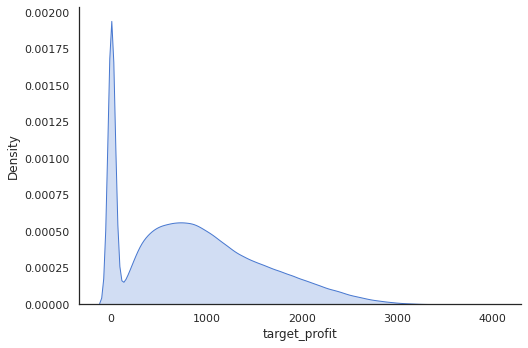

In [133]:
sns.set(color_codes=True)
sns.set(style="white", palette="muted")

#palette=sns.color_palette('bright')[:5]

for col in target.columns:
    sns.displot(target[col], legend=True,
                kind='kde', fill=True, 
                height=5, aspect=1.5)

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).


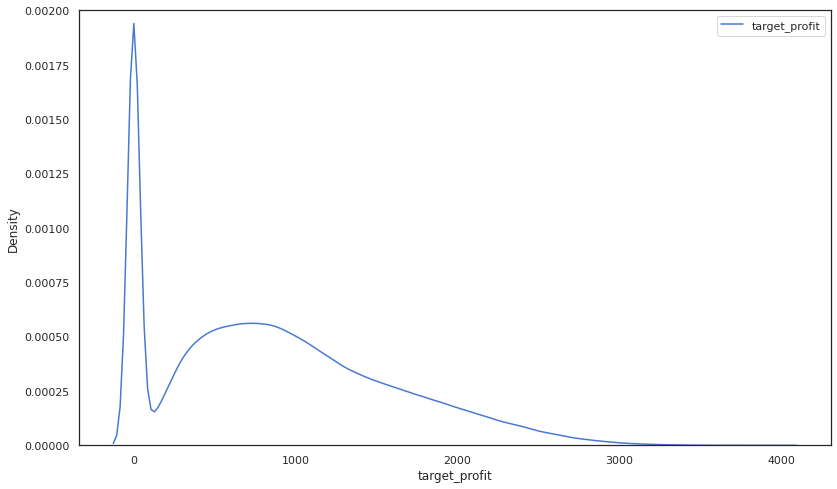

In [152]:
plt.rcParams["figure.figsize"] = [12, 8]
f, (ax1) = plt.subplots(1,1)

for col in target.columns:
    x = target[col]
    sns.distplot(x,
                 bins = 'auto',
                 norm_hist = True,
                 hist = False,
                 kde = True,
                 rug = False,
                 ax = ax1,
                 label = col
                )
    ax1.legend()
    ax1.set_ylim(top=0.002)
#     ax1.relim()
    ax1.autoscale_view()
plt.show()

In [ ]:
sns.pairplot(target)

## Splits

In [447]:
# treat_gr_size = data.loc[data.target_group_flag==1, :].shape[0]

In [448]:
# treat = data.loc[data.target_group_flag==1, :].reset_index(drop=True)
# control = data.loc[data.target_group_flag==0, :].sample(n=treat_gr_size).reset_index(drop=True)

In [39]:
_data = data #pd.concat((treat, control), axis=0).reset_index(drop=True)

In [40]:
fit_index, val_index = train_test_split(_data.index, test_size=0.5, random_state=165)

## Model

In [41]:
selected_cols = \
[   
#  'ohe__location__Beauclair',
#  'ohe__location__Crows_perch',
#  'ohe__location__Hindarsfjall',
#  'ohe__location__Kaer_Trolde',
#  'ohe__location__Novigrad',
#  'ohe__location__Oxenfurt',
#  'ohe__location__Spikeroog', 
#  'purchase_amt_sum__2d',
#  'purchase_amt_mean__2d',     
#  'purchase_amt_max__2d',    
#  'purchase_amt_min__2d',
#  'purchase_amt_sum__5d', 
#  'purchase_amt_mean__5d',     
#  'purchase_amt_max__5d',    
#  'purchase_amt_min__5d',
 'purchase_amt_sum__7d',
#  'purchase_amt_mean__7d',     
#  'purchase_amt_max__7d',    
#  'purchase_amt_min__7d',
#  'purchase_amt_sum__10d',
 'purchase_amt_mean__10d',    
 'purchase_amt_max__10d',    
#  'purchase_amt_min__10d',
 'purchase_amt_sum__15d',
 'purchase_amt_mean__15d',    
#  'purchase_amt_max__15d',
 'purchase_amt_min__15d',
 'purchase_amt_sum__20d',
 'purchase_amt_mean__20d',    
 'purchase_amt_max__20d',
 'purchase_amt_min__20d',
 'purchase_amt_sum__25d',
 'purchase_amt_mean__25d',    
#  'purchase_amt_max__25d',
 'purchase_amt_min__25d',
 'purchase_amt_sum__31d',
 'purchase_amt_mean__31d',    
 'purchase_amt_max__31d',
#  'purchase_amt_min__31d',    
#  'purchase_amt_sum__35d',
 'purchase_amt_mean__35d',    
#  'purchase_amt_max__35d',
#  'purchase_amt_min__35d',
 'purchase_amt_sum__40d',
 'purchase_amt_mean__40d',    
 'purchase_amt_max__40d',
 'purchase_amt_min__40d',
#  'purchase_amt_sum__45d',
#  'purchase_amt_mean__45d',    
#  'purchase_amt_max__45d',
#  'purchase_amt_min__45d',    
 'purchase_amt_sum__50d',
 'purchase_amt_mean__50d',    
#  'purchase_amt_max__50d',
 'purchase_amt_min__50d',
#  'purchase_amt_sum__55d',
#  'purchase_amt_mean__55d',    
#  'purchase_amt_max__55d',
#  'purchase_amt_min__55d',    
 'purchase_amt_sum__60d',
 'purchase_amt_mean__60d',     
 'purchase_amt_max__60d',
#  'purchase_amt_min__60d',
 'purchase_amt_sum__65d',
 'purchase_amt_mean__65d',     
 'purchase_amt_max__65d',
#  'purchase_amt_min__65d',
 'purchase_amt_sum__70d',
 'purchase_amt_mean__70d',     
 'purchase_amt_max__70d',
 'purchase_amt_min__70d',    
#  'purchase_amt_sum__75d',
#  'purchase_amt_mean__75d',     
#  'purchase_amt_max__75d',
#  'purchase_amt_min__75d',    
#  'purchase_sum_sum__2d',    
#  'purchase_sum_max__2d',    
#  'purchase_sum_min__2d',
#  'purchase_sum_sum__5d',    
#  'purchase_sum_max__5d',    
#  'purchase_sum_min__5d',
#  'purchase_sum_sum__7d',    
#  'purchase_sum_max__7d',    
#  'purchase_sum_min__7d',
#  'purchase_sum_sum__10d',    
#  'purchase_sum_max__10d',    
#  'purchase_sum_min__10d',
#  'purchase_sum_sum__15d',
#  'purchase_sum_max__15d',
#  'purchase_sum_min__15d',
#  'purchase_sum_sum__20d',
#  'purchase_sum_max__20d',
#  'purchase_sum_min__20d',
#  'purchase_sum_sum__25d',
#  'purchase_sum_max__25d',
#  'purchase_sum_min__25d',
#  'purchase_sum_sum__35d',
#  'purchase_sum_max__35d',
#  'purchase_sum_min__35d',
#  'purchase_sum_sum__40d',
#  'purchase_sum_max__40d',
#  'purchase_sum_min__40d',
#  'purchase_sum_sum__50d',    
#  'purchase_sum_max__50d',
#  'purchase_sum_min__50d',
#  'purchase_sum_sum__60d',    
#  'purchase_sum_max__60d',
#  'purchase_sum_min__60d',
#  'date_count__7d',
#  'date_count__35d',
#  'date_count__60d', 
#  'mean_time_interval__2d', 
#  'mean_time_interval__5d',    
#  'mean_time_interval__7d',
#  'mean_time_interval__10d',
#  'mean_time_interval__15d',
 'mean_time_interval__20d',    
#  'mean_time_interval__25d',
#  'mean_time_interval__31d',    
 'mean_time_interval__35d',
 'mean_time_interval__40d',
 'mean_time_interval__45d',    
#  'mean_time_interval__50d',
#  'mean_time_interval__55d',    
#  'mean_time_interval__60d', 
#  'mean_time_interval__65d',
#  'mean_time_interval__70d',
#  'mean_time_interval__75d',    
#  'time_since_last__2d', 
#  'time_since_last__5d',    
#  'time_since_last__7d', 
#  'time_since_last__10d', 
#  'time_since_last__15d',
#  'time_since_last__20d',    
#  'time_since_last__25d',     
#   'time_since_last__35d',
#  'time_since_last__40d',    
#  'time_since_last__50d',
#  'time_since_last__55d',    
#  'time_since_last__60d', 
#  'time_since_last__65d',    
#  'time_since_last__70d',
#  'time_since_last__75d', 
#  'purchase_sum_per_day__5d', 
#  'purchase_sum_per_day__15d', 
#  'purchase_sum_per_day__25d', 
#  'purchase_sum_per_day__35d', 
#  'purchase_sum_per_day__50d', 
#  'purchase_sum_per_day__60d', 
#  'age_bin' 
]

In [42]:
col_target = 'target_profit'
col_treatment = 'target_group_flag'
cols_features = selected_cols

In [43]:
model_n1 = rlearner.BaseRRegressor(
    learner=lgb.LGBMRegressor(),
    control_name=0,
    n_fold=4,
    random_state=165
)

In [44]:
_p_score_const = _data.loc[fit_index, col_treatment].value_counts(normalize=True).loc[1]
_p_score_const

0.250246

In [45]:
_p_scores = pd.Series(data=_p_score_const, index=fit_index)

model_n1.fit(
    X=_data.loc[fit_index, cols_features].values,
    treatment=_data.loc[fit_index, col_treatment].values,
    y=_data.loc[fit_index, col_target].values,
    p=_p_scores
)

# FEATURE IMPOT

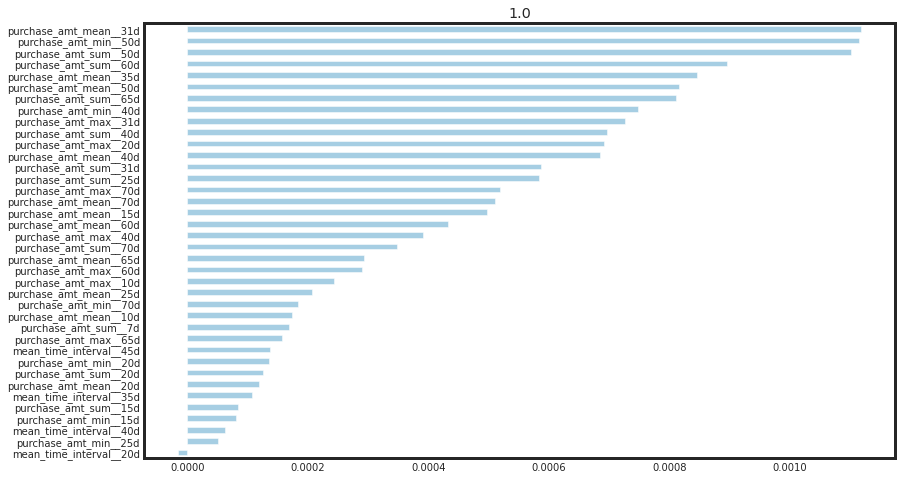

In [28]:
plt.rcParams["figure.figsize"] = [12, 18]
model_n1.plot_importance(X=_data.loc[fit_index, cols_features], 
                         tau=_data.loc[fit_index, col_treatment], 
                         method='permutation',
                         features = cols_features)

## evaluate model

In [46]:
_eval_data = _data.loc[val_index, cols_features + [col_treatment, col_target]]
_eval_data['score'] = model_n1.predict(_eval_data[cols_features])
_eval_data = _eval_data[['score', col_treatment, col_target]]

In [406]:
np.percentile(_eval_data['score'], 5), np.percentile(_eval_data['score'], 95)

(-35.914389975328376, 30.476414034324215)

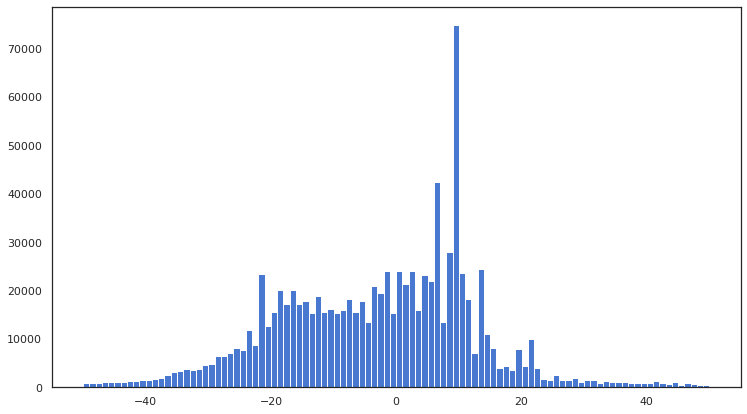

In [436]:
plt.figure(figsize=(11, 7))
plt.hist(_eval_data['score'], range=(-50, 50.), bins=100)
plt.show()

## GAIN Target_1

### Don't Include 30-th day starting from 102 

In [47]:
_eval_data['score'].describe()

count    1000000.000000
mean          -3.395178
std           33.244351
min         -840.602332
25%          -16.548044
50%           -2.515475
75%           10.873659
max         1024.462978
Name: score, dtype: float64

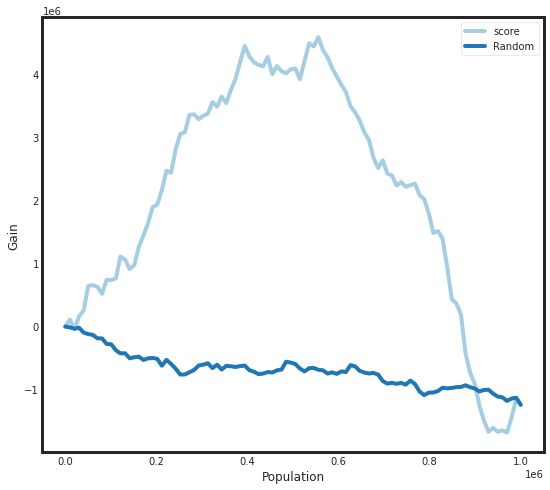

In [48]:
cmetrics.plot_gain(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col=col_target,
)

In [49]:
cmetrics.qini_score(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col=col_target,
)

score     2.251742
Random    0.000000
dtype: float64

### Include 30-th day starting from 102 

In [24]:
_eval_data['score'].describe()

count    1000000.000000
mean          -2.452549
std           31.820855
min         -711.954425
25%          -13.270398
50%           -2.623869
75%            8.704677
max          950.264825
Name: score, dtype: float64

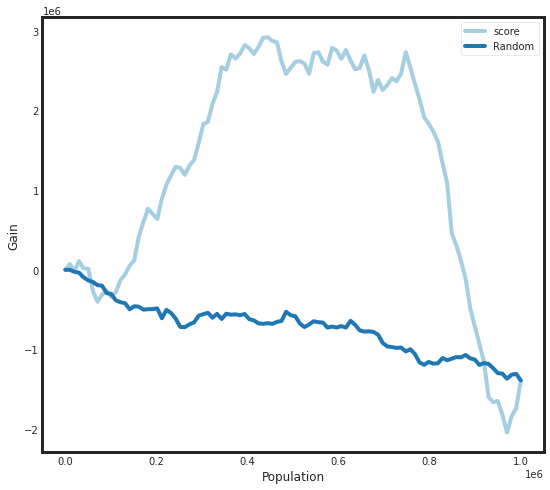

In [29]:
cmetrics.plot_gain(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col=col_target,
)

In [26]:
cmetrics.qini_score(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col=col_target,
)

score     1.455418
Random    0.000000
dtype: float64

## GAIN Target_2

In [441]:
_eval_data['score'].describe()

count    1000000.000000
mean          -1.595916
std           34.724932
min        -1013.703612
25%          -15.206372
50%           -2.470441
75%           14.338375
max          933.633009
Name: score, dtype: float64

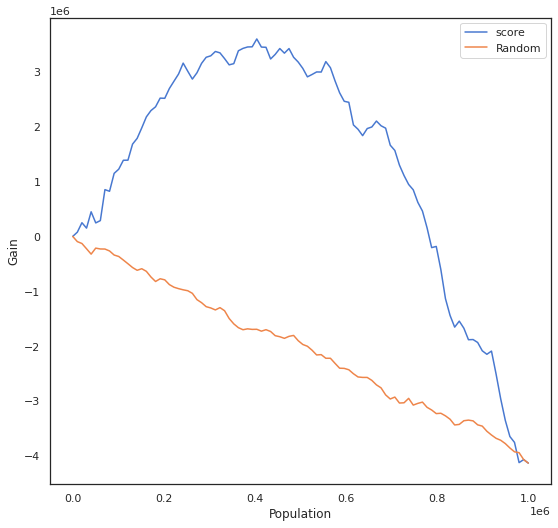

In [442]:
cmetrics.plot_gain(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col=col_target,
)

In [443]:
cmetrics.qini_score(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col=col_target,
)

score     0.804686
Random    0.000000
dtype: float64

## OOT: Predict

In [57]:
data_config = {
    'extract': [
        {
            'name': 'receipts_basic',
            'args': {'delta': 75, 'date_to': 250}
        },        
        {
            'name': 'receipts_basic',
            'args': {'delta': 70, 'date_to': 250}
        },        
        {
            'name': 'receipts_basic',
            'args': {'delta': 65, 'date_to': 250}
        },        
        {
            'name': 'receipts_basic',
            'args': {'delta': 60, 'date_to': 250}
        },
        {
            'name': 'receipts_basic',
            'args': {'delta': 55, 'date_to': 250}
        },         
        {
            'name': 'receipts_basic',
            'args': {'delta': 50, 'date_to': 250}
        }, 
        {
            'name': 'receipts_basic',
            'args': {'delta': 45, 'date_to': 250}
        },        
        {
            'name': 'receipts_basic',
            'args': {'delta': 40, 'date_to': 250}
        },         
        {
            'name': 'receipts_basic',
            'args': {'delta': 35, 'date_to': 250}
        },
        {
            'name': 'receipts_basic',
            'args': {'delta': 31, 'date_to': 250}
        },        
        {
            'name': 'receipts_basic',
            'args': {'delta': 25, 'date_to': 250}
        }, 
        {
            'name': 'receipts_basic',
            'args': {'delta': 20, 'date_to': 250}
        },         
        {
            'name': 'receipts_basic',
            'args': {'delta': 15, 'date_to': 250}
        },
        {
            'name': 'receipts_basic',
            'args': {'delta': 10, 'date_to': 250}
        },
        {
            'name': 'receipts_basic',
            'args': {'delta': 7, 'date_to': 250}
        },
        {
            'name': 'receipts_basic',
            'args': {'delta': 5, 'date_to': 250}
        },        
        {
            'name': 'receipts_basic',
            'args': {'delta': 2, 'date_to': 250} 
        },    
        {
            'name': 'age_gender',
            'args': {}
        }
    ],
    'transform': [
        {
            'name': 'one_hot_encode',
            'args': {
                'cols': ['location']
            }
        },
        {
            'name': 'binning',
            'args': {
                'col_value': 'age',
                'col_result': 'age_bin',
                'bins': np.linspace(age_min, age_max, BINS).tolist(),
                'labels': range(0, min(unique_age, BINS)+1)
            }
        },          
    ]
}


In [58]:
_raw_data = fcompute.extract_features(engine, config=data_config['extract'])

In [59]:
_raw_data = raw_data_.compute()

## FillNa

In [60]:
for col in raw_data_.columns:
    if (col.startswith("purchase_") or 
        col.startswith("discount_") or 
        col.startswith("date_count_") or
        col.startswith("mean_time_interval_") or
        col.startswith("time_since_last_")
       ):
        _raw_data = _raw_data.fillna(value={col:0}) 

## OOT Transform

In [61]:
transform_pipeline = fcompute.create_pipeline(data_config['transform'])

In [62]:
oot_data = transform_pipeline.fit_transform(_raw_data.copy())

## OOT EVAL

In [440]:
_eval_data = oot_data.loc[:, cols_features + ['customer_id']]
_eval_data['score'] = model_n1.predict(_eval_data[cols_features])

In [441]:
_eval_data['score'].describe()

count    2.000000e+06
mean    -2.698447e+00
std      3.499903e+01
min     -8.108486e+02
25%     -1.548640e+01
50%     -1.221625e+00
75%      9.443374e+00
max      1.061654e+03
Name: score, dtype: float64

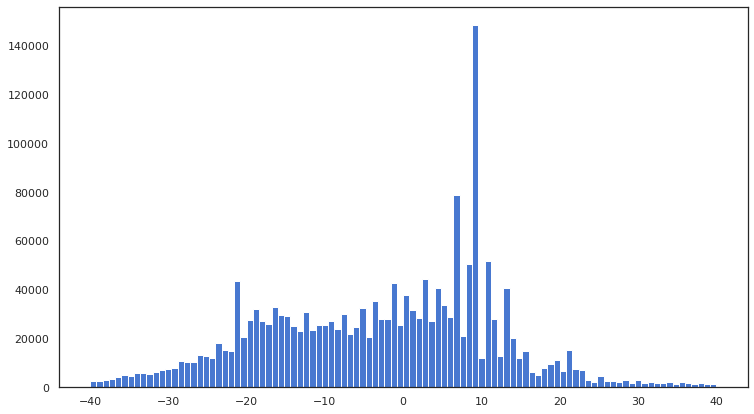

In [442]:
plt.figure(figsize=(11, 7))
plt.hist(_eval_data['score'], range=(-40, 40.), bins=100)
plt.show()

### Cut-Off

In [478]:
cutoff = np.percentile(_eval_data['score'], 55)
cutoff

1.3009398157238228

In [479]:
_eval_data['make_offer'] = (_eval_data['score'] >= cutoff).astype(int)

In [480]:
_eval_data[['customer_id', 'score', 'make_offer']].head()

,customer_id,score,make_offer
0,0,-19.334973,0
1,1,1.673144,1
2,2,75.147428,1
3,3,44.070406,1
4,4,10.676950,1


In [481]:
_eval_data.make_offer.value_counts()

0    1100000
1     900000
Name: make_offer, dtype: int64

In [482]:
## If file exists, delete it ##
csvf ='./csv/make_offer.csv'
if os.path.isfile(csvf):
    os.remove(csvf)
else:    ## Show an error ##
    print("Error: %s file not found" % csvf)

In [483]:
_eval_data.query("make_offer > 0")[['customer_id']].to_csv('./csv/make_offer.csv', index=False)